In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data

,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,stdev_alpha,...,ret1d_lag,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag
0,19950103,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19941230.0,8056,0.010006,0.004670,...,0.00000,-0.003112,0.176850,0.166677,0.131841,0.102035,0.144700,0.123317,0.138261,0.106187
1,19950104,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950103.0,8057,-0.003112,0.004656,...,0.01929,0.019820,0.131835,0.124719,0.125412,0.099894,0.173638,0.151438,0.144692,0.115932
2,19950105,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950104.0,8058,0.019820,0.005805,...,0.04732,0.045571,0.119876,0.112258,0.094651,0.075155,0.170357,0.145504,0.135652,0.101416
3,19950106,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950105.0,8059,0.045571,0.009709,...,0.03313,0.032296,0.069278,0.054748,0.063264,0.050293,0.096391,0.070299,0.090370,0.047479
4,19950109,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950106.0,8060,0.032296,0.010892,...,0.06706,0.063220,0.058317,0.037605,0.020420,0.006697,0.046651,0.026290,0.072892,0.026535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912427,20210805,78696,COOK,Traeger Inc,7.0,20210805,20210804.0,6,0.047968,0.026349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912428,20210806,78722,WEBR,Weber Inc Cl A,NaN,20210809,20210805.0,2,0.000000,0.000000,...,0.08190,0.080042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912429,20210809,78722,WEBR,Weber Inc Cl A,7.0,20210809,20210806.0,3,0.080042,0.025773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912430,20210901,78803,FCUV,Focus Universal Inc,NaN,20210902,20210831.0,2,0.000000,0.000000,...,-0.07106,-0.072293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now, let's trade on the times when there is a stock split or reverse split

In [3]:
#define event using indicator for buy and sell:
data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data['buy_tomorrow'] = ((data['epshigha1'] / data['epsa1']) < 1.02)
data['sell_tomorrow'] = ((data['epshigha1'] / data['epsa1']) > 1.2)


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was included in 2 indices in one day!
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was removed from 2 indices in one day!




Total number of Buys:  286097
Total number of Sells:  308518
Unique buy_tomorrow values:  [False  True]
Unique sell_tomorrow values:  [False  True]


In [4]:
data = cp.trade_on_valid_lags_only(data)


There are  13  problems for buying

There are  8  problems for selling
Total number of Buys:  286084
Total number of Sells:  308510


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [5]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)




There are  15  problems for buying

There are  9  problems for selling
Total number of Buys:  358638
Total number of Sells:  374932

There are  14  problems for buying

There are  9  problems for selling
Total number of Buys:  341183
Total number of Sells:  359309

There are  13  problems for buying

There are  9  problems for selling
Total number of Buys:  322789
Total number of Sells:  342628

There are  13  problems for buying

There are  9  problems for selling
Total number of Buys:  303257
Total number of Sells:  324726

There are  13  problems for buying

There are  8  problems for selling
Total number of Buys:  285935
Total number of Sells:  308410


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.118
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           2.96e-05
Time:                        16:32:50   Log-Likelihood:                 17165.
No. Observations:                6539   AIC:                        -3.432e+04
Df Residuals:                    6532   BIC: 

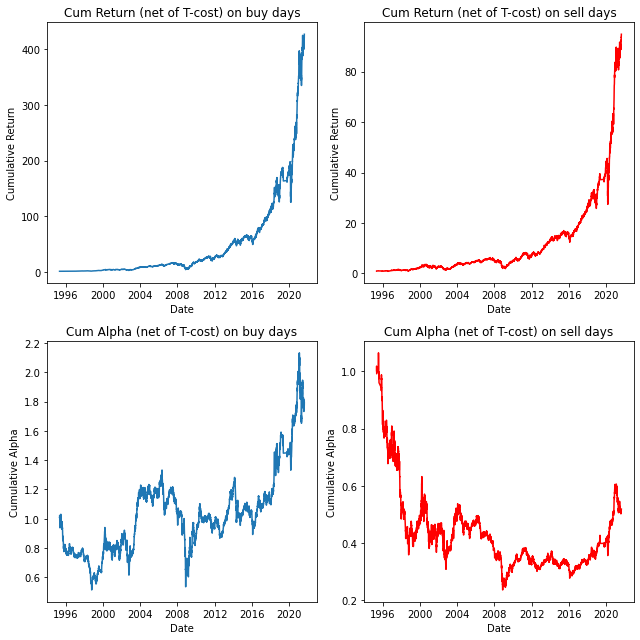

In [6]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.121
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           2.94e-05
Time:                        16:33:04   Log-Likelihood:                 17243.
No. Observations:                6546   AIC:                        -3.447e+04
Df Residuals:                    6539   BIC: 

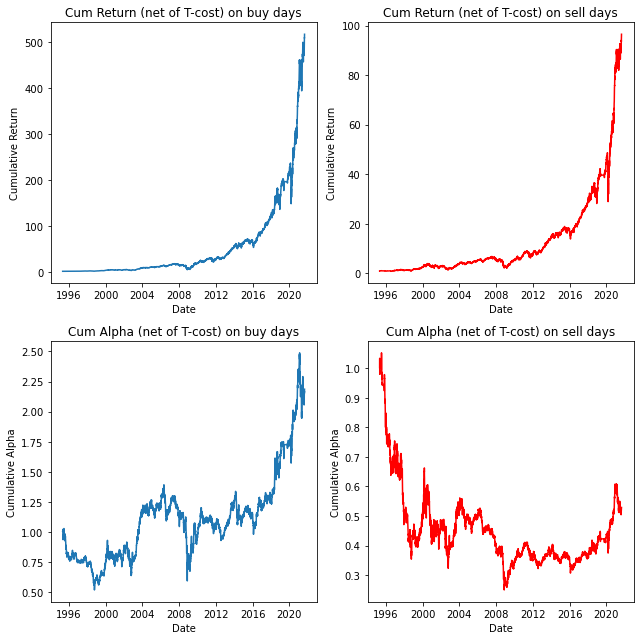

In [7]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.033
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           3.70e-05
Time:                        16:33:19   Log-Likelihood:                 17326.
No. Observations:                6551   AIC:                        -3.464e+04
Df Residuals:                    6544   BIC: 

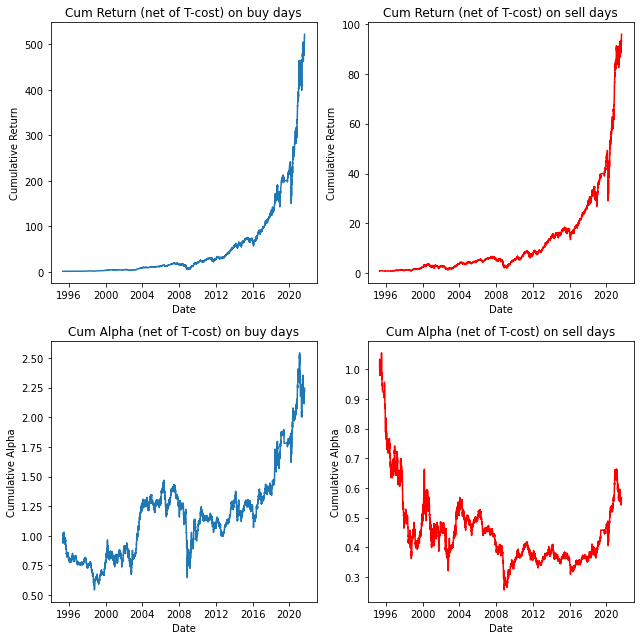

In [8]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  3  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.011
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           3.92e-05
Time:                        16:33:33   Log-Likelihood:                 17394.
No. Observations:                6556   AIC:                        -3.477e+04
Df Residuals:                    6549   BIC: 

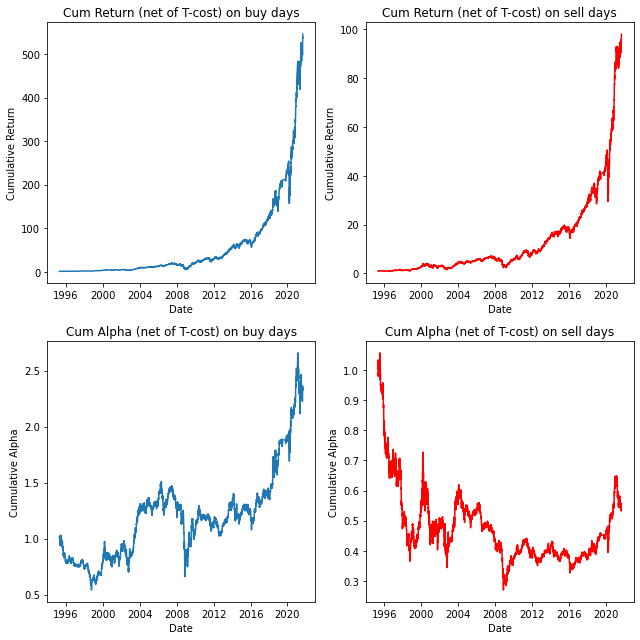

In [9]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  3  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.168
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           2.60e-05
Time:                        16:33:48   Log-Likelihood:                 17460.
No. Observations:                6561   AIC:                        -3.491e+04
Df Residuals:                    6554   BIC: 

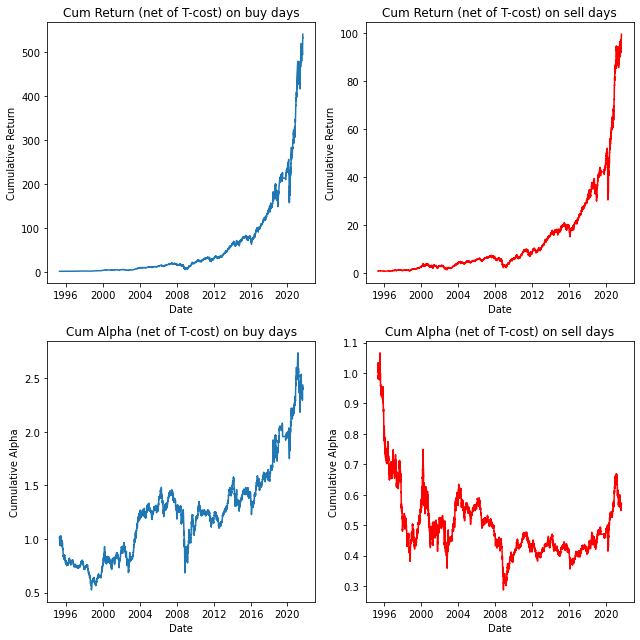

In [10]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)